Question 1: Use any GAN of your choice (preferably DCGAN) to generate images from noise. Perform the
following experiments.

A. Use the CIFAR 10 database to learn the GAN network. Generate images once the learning is complete.

B. Plot generator and discriminator losses and show how can you ascertain the convergence of the GAN

To perform the experiments on DCGAN for generating images, we'll need to follow several steps:

1. Prepare the CIFAR-10 dataset: Download and preprocess the CIFAR-10 dataset.

2. Build the DCGAN: Define the architecture for the generator and discriminator networks.

3. Train the DCGAN: Train the DCGAN using the CIFAR-10 dataset.

4. Generate Images: Use the trained generator to generate images from noise.


In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam



2024-02-21 12:35:41.197933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 12:35:41.198023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 12:35:41.199579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 12:35:41.209181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 12:35:42.496366: W tensorflow/compiler/tf2

In [3]:
(X_train, _), (_, _) = cifar10.load_data()
X_train = (X_train - 127.5) / 127.5  # Normalize images to [-1, 1]
X_train = X_train.reshape(-1, 32, 32, 3).astype(np.float32)

In [4]:
def build_generator():
    generator = Sequential([
        Dense(4 * 4 * 256, input_shape=(100,)),
        Reshape((4, 4, 256)),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu'),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'),
        Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')  # 3 channels for RGB image
    ])
    return generator

In [5]:
def build_discriminator():
    discriminator = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(32, 32, 3), activation='relu'),
        Conv2D(128, kernel_size=4, strides=2, padding='same', activation='relu'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return discriminator

In [6]:
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [7]:
discriminator.trainable = False

gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer=Adam())


In [8]:
# Training loop
batch_size = 128
epochs = 10

for epoch in range(epochs):
    for i in range(X_train.shape[0] // batch_size):
        # Train discriminator
        noise = np.random.normal(0, 1, size=(batch_size, 100))
        fake_images = generator.predict(noise)
        real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
        X = np.concatenate([real_images, fake_images])
        y = np.zeros(2 * batch_size)
        y[:batch_size] = 0.9  # Label smoothing for real images
        discriminator.train_on_batch(X, y)

4/4 [==============================] - 0s 10ms/step


In [12]:
noise = np.random.normal(0, 1, size=(batch_size, 100))
y = np.ones(batch_size)
gan.train_on_batch(noise, y)
print(f'Epoch {epoch + 1}/{epochs}')

Epoch 10/10


In [13]:
def generate_images(generator, n_images=10):
    noise = np.random.normal(0, 1, size=(n_images, 100))
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]
    return generated_images

1/1 [==============================] - 0s 122ms/step


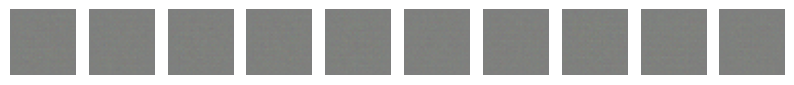

In [14]:
generated_images = generate_images(generator)
plt.figure(figsize=(10, 10))
for i in range(generated_images.shape[0]):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.show()

B. Plot generator and discriminator losses and show how can you ascertain the convergence of the GAN
training process.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Input
from tensorflow.keras.optimizers import Adam


In [20]:
(X_train, _), (_, _) = cifar10.load_data()
X_train = (X_train - 127.5) / 127.5  # Normalize images to [-1, 1]


In [27]:
def build_generator():
    generator = Sequential([
        Dense(4 * 4 * 128, input_shape=(100,)),  # Adjusted input shape
        Reshape((4, 4, 128)),  # Reshape the noise vector
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu'),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'),
        Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='tanh')  # Adjusted strides for proper output shape
    ])
    return generator


In [28]:
def build_discriminator():
    discriminator = Sequential([
        Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(32, 32, 3), activation='relu'),
        Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return discriminator


In [29]:
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

discriminator.trainable = False
gan_input = Input(shape=(100,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))


In [30]:
def train_gan(epochs, batch_size, sample_interval):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(real_images, real)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real)
        # Plot the progress
        if epoch % sample_interval == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
            # Sample generated images
            sample_images(epoch)
            # Plot losses
            plot_losses(d_loss, g_loss)


In [31]:
def plot_losses(d_loss, g_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(d_loss, label='Discriminator loss')
    plt.plot(g_loss, label='Generator loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Losses')
    plt.show()

In [32]:
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

4/4 [==============================] - 1s 8ms/step
Epoch 0, D Loss: 0.7037869095802307, G Loss: 0.6800224184989929
1/1 [==============================] - 0s 124ms/step


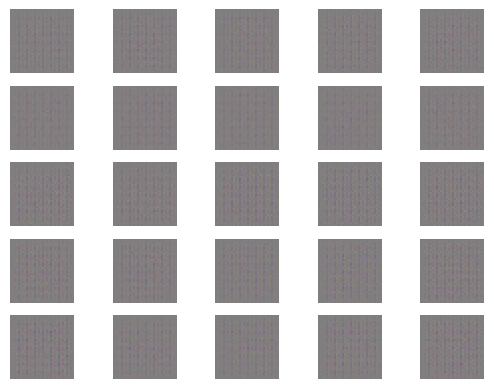

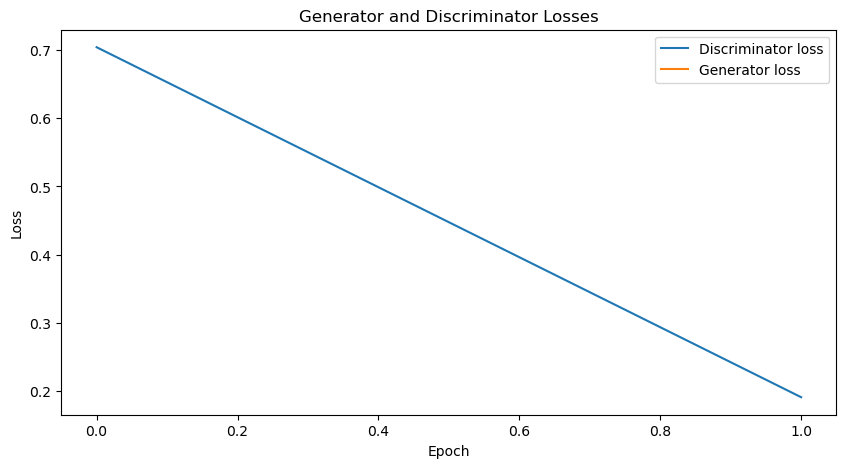

4/4 [==============================] - 0s 7ms/step
Epoch 1000, D Loss: 0.6580633521080017, G Loss: 0.7986844778060913
1/1 [==============================] - 0s 34ms/step


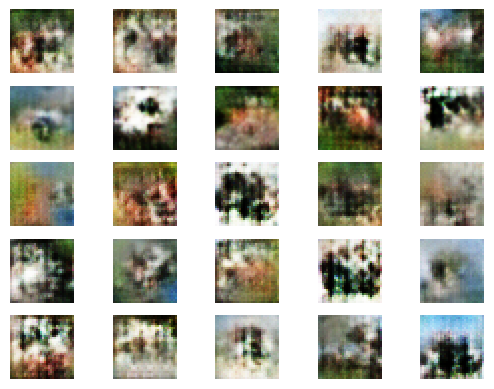

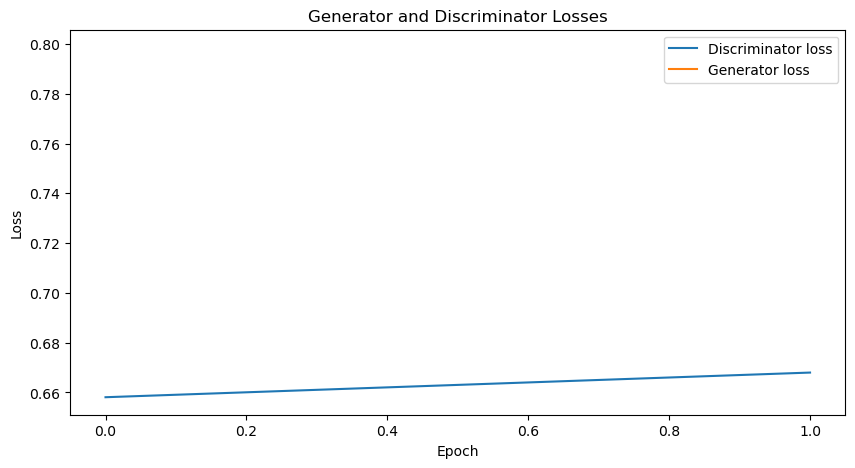

4/4 [==============================] - 0s 8ms/step
Epoch 2000, D Loss: 0.6653677523136139, G Loss: 0.7995527982711792
1/1 [==============================] - 0s 35ms/step


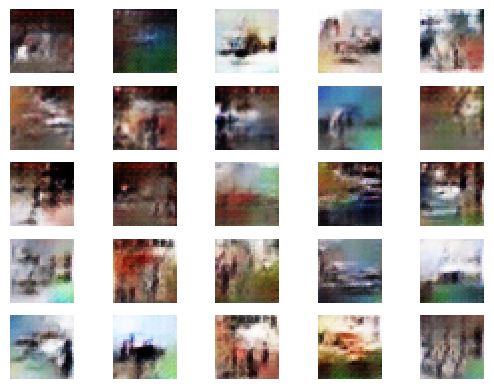

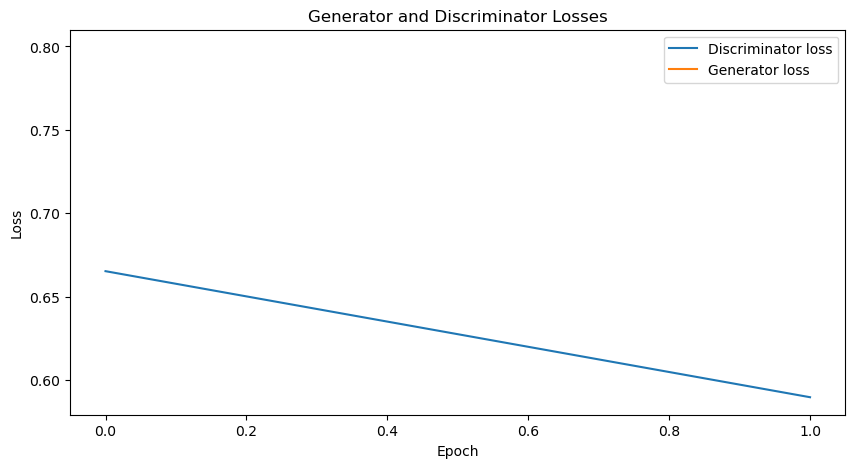

4/4 [==============================] - 0s 7ms/step


In [ ]:
epochs = 20000
batch_size = 128
sample_interval = 1000

train_gan(epochs, batch_size, sample_interval)